## Forecasting using Supervised Machine Learning

Here we will explore different machine learning algorithms for time series forecasting. ML algos can be grouped into: **Supervised learning** and **unsupervised learning** and **reinforcement learning**

This chapter will focus on _supervised learning_.

We will explore two ML libraries: **scikit-learn** and **sktime**. Scikit-learn is a popular ML library in Python that offers a wide range of algorithms for supervised and unsupervised learning and a plethora of tools for data preprocessing, model evaluation and selection. 

**Sktime** library from the Alan Turing institute is a dedicated ML library for time series data

In [3]:
# Importing common libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from pathlib import Path
import warnings 
warnings.filterwarnings('ignore')

In [4]:
path = Path('../TimeSeriesAnalysisWithPythonCookbook/Data/')

daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                         index_col='DateTime', 
                         parse_dates=True)
daily_temp.columns = ['y']

energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                     index_col='date', 
                     parse_dates=True)
energy.columns = ['y']

In [5]:
# Then add the proper frequency for each DataFrame
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'


<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

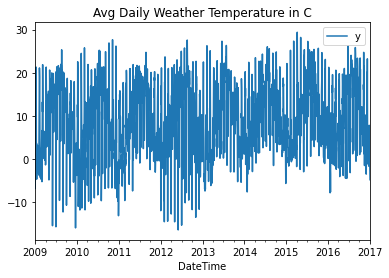

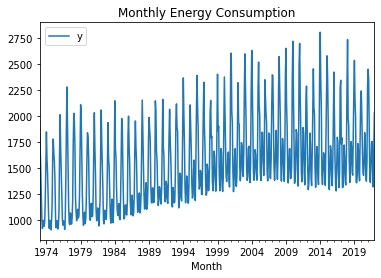

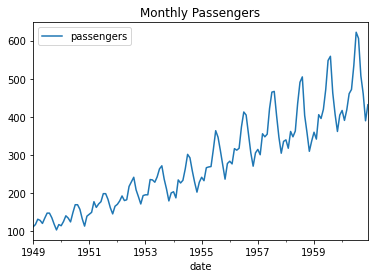

In [6]:
# Plot the three DataFrames to gain an understanding of how they differ
daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')


## Understanding supervised machine learning 

In supervised ML the data used for training contains past outcomes, referred to as dependent or target variables. These are the variables we want our ML model to predict. The ML algorithm learns from the data using all other variables, known as independent or predictor variables, to determine how they are used to estimate the target variable. For example, the target variable is the house price in the house pricing prediction problem. The other variables, such as the number of bedrooms, number of bathrooms, total square footage, and city are the independent variables used to train the model. We can think of the ML model as a mathematical model for making predictions on unobserved outcomes. 

On the other hand, in unsupervised ML, the data contains no labels or outcomes to train on. Unsupervised algorithms are used to find patterns in the data, such as the case with clustering, for example, customer segmentation, anomaly detection or recommender systems.

There are two types of supervised ML:

* classification 
* regression

In classification, the goal is to predict which class (or label) a particular observation belongs to. In other words we are predicting a discrete value, for example whether an email is spam or nor or whether a transaction is fraudulent or not. The two examples represent a binary classification problem, but we can have a multi-class classification problem, such as the case with image classification. Some popular classification algorithms include _Logistic Regression, Random Forests, K-Nearest neighbours, and Support Vector Machines_

In regression, we predict a continous variable, such as the price of a house or a preson's height. In regression, we can have a simple linear regression problem with one independent variable and one target variable, a multiple regression problem with more than one independent variable and one target variable, or a multivariate multiple regression problem with more than one independent variable and more than one dependent variable. Some popular Linear regression algorithms include _Linear regression, Lasso regression and Elastic Net Regression_ These examples are considered linear algorithms that assume a linear relationship between the variables. 

Interestingly, several of the classification algorithms mentioned earlier can be used for regession; for example, we can have a Random Forest Regression, K-Nearest Neighbors Regression and Support Vector Machines Regression. These regressors can capture non-linear relationships and produce more complex models. 

## Preparing time series data for supervised learning 

In supervised ML, we must specify the independent variables (predictors) and the dependent variable (target). Generally, preparing the time series data is similar to what we have done in previous chapters. The following highlights the overall steps: 

1) Inspect the time series data to ensure there are no significant gaps, such as missing data. If there are gaps, evaluate the impact and consider some of the imputation and interpolation techniques 

2) Under stationarity assumptions in the algorithm before fitting the model. 

3) Transform the time series to contain independent and dependent variables. To do this, we will define a sliding window to convert the data into a window of inputs. For example, if we decide that the past five periods (lags) should be used to predict the current period (the sixth), then we will create a sliding window of five periods. This will transform a univariate time series into a tabular format. A univariate time series has only one dependent variable and no independent variables. For example, a five-period sliding window will produce five independent variables: $x_{1}, x_{2}, x_{3}, x_{4}, x_{5}$ which are lagged versions of the dependent variable. This representation of multiple inputs to one output is referred to as a one-step forecast. This will be the focus of this recipe. 

4) Before training a model, split it into training, validation, and test sets

5) Depending on the algorithm, we may need to scale our data; for example in scikit-learn, we can leverage the **StandardScaler** or the **MinMaxScaler** class. When making our predictions, we will need to _inverse_ the transform to restore the results to their original scale, for example we can use the _inverse_transform_ method from scikit-lean




In [7]:
# Inspect for missing data. If there is missing data, then perform a simple fill forward imputation
# First, make a copy so we do not change the original DataFrame

air_copy = air.copy()
energy_copy = energy.copy()
daily_temp_copy = daily_temp.copy()

In [8]:
# Create the handle_missing_data function 
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0: 
        print(f'found {n} mising observations...')
        df.ffill(inplace=True)
        

In [9]:
# Pass each dataframe to the handle_missing function 

for df in [air_copy, energy_copy, daily_temp_copy]:
    handle_missing_data(df)



found 2 mising observations...


In [10]:
# Create the one-step_forecast function, which returns a DataFrame with a specified number of 
# independent variables and a target variable. The total number of columns returned is based 
# on the sliding window parameter (number of columns = sliding window + 1)

def one_step_forecast(df, window):
    d = df.values 
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)

    return pd.concat([df_y, df_xs], axis=1).dropna()



In [11]:
# Transform all five three DF with same sliding window (5)

air_os = one_step_forecast(air_copy, 5)
energy_os = one_step_forecast(energy_copy, 5)
daily_temp_os = one_step_forecast(daily_temp_copy, 5)

In [12]:
# We will need to split the data into training and test sets. Create the split_data function
# to split the data 

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test 


In [13]:
# Using the split function 
train, test = split_data(air_os)
print(f'Train: {len(train)} Test: {len(test)}')


Train: 119 Test: 20


Certain algorithms benefit from scaling the data. We can use the **StandardScaler** class from scikit-learn. Here we will create the **Standardize** class with three methods: 
* fit_transform: fit on the training data and then transforms both the training and test sets
* inverse: return a DF to its original scale
* inverse_y: to inverse the target variable (or a specific column and not the entire DF)


In [14]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split 

    def _transform(self, df):
        return (df - self.mu)/ self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test 
    
    def fit_transform(self, train, test): 
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        return train_s, test_s 
    def inverse(self, df): 
        return (df * self.sigma)+self.mu 
    
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [15]:
# Using the Standardize class
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train,test)
train_original = scaler.inverse(train_s)
y_train_original = scaler.inverse_y(train_s['y'])


In [16]:
# Example of engineering date time related features using pandas: 
df['day_of_week'] = df.index.dayofweek
df['days_in_month'] = df.index.days_in_month
df['month_end'] = df.index.is_month_end.astype(int)
df['is_leap'] = df.index.is_leap_year.astype(int)
df['month'] = df.index.month
df.head()


,y,day_of_week,days_in_month,month_end,is_leap,month
DateTime,,,,,,
2009-01-01,-6.810629,3,31,0,0,1
2009-01-02,-3.360486,4,31,0,0,1
2009-01-03,5.435694,5,31,0,0,1
2009-01-04,7.283889,6,31,0,0,1
2009-01-05,12.690069,0,31,0,0,1


## One-step forecasting using linear regression models with scikit-learn 

The independent variables that were created $(X_{1}, X_{1}, ..., X_{1})$ are lagged versions of the dependent variable (Y) created using a sliding window. We can simplify the equation in matrix notation by adding an $X_{0}$ term, which is a constant value of one ($X_{0}=1$). This will give the following equation: $\hat{y} = \beta X + \epsilon$

We want to minimize the cost function (RSS) given by the objective function: 

$min \sum_{i=1}^{n}(Y_{i} - \sum_{j=0}^{m} \beta _{j} X_{ij})^{2}$

Sometimes we will see the objective function as minimizing the **mean squared error (MSE)**, which is obtained by divinding the RSS by the degrees of freedom



In [17]:
from sklearn.linear_model import (LinearRegression, ElasticNet, Ridge, Lasso, HuberRegressor)

air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()


In [18]:
# Use the handle_missing_data function to ensure there are no missing values

#handle_missing_data(en_cp)

for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)




found 2 mising observations...


In [19]:
# Use one_step_forecast to convert the time series DataFrames into a supervised learning
# problem with 10 steps 
air_reg = one_step_forecast(air_cp, 10)
en_reg = one_step_forecast(en_cp, 10)
dw_reg = one_step_forecast(dw_cp, 10)


In [20]:
# Split and scale the data using the split_data function and the Standardize class 
# Later, we can use the class instance to inverse the scaling 

train_en, test_en = split_data(en_reg, test_split=0.10)

scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)


train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw, test_dw)

Common error metrics used in regression are: 

* **Mean Squared Error (MSE)** 
* **Root Mean Squared Error (RMSE)** 
These are scale-dependent, so if we for example scale our data using the **Standardize** class function, this will impact the scores and make it difficult to compare.

* **Mean Absolute Percentage Error (MAPE)** - which is more intuitive to interpret since it is expressed as a percentage and is scale-independent. For certain problems, MAPE may not be suitable:
    - MAPE puts heavier penalty on negative errors 
    - Cannot divide by zero 

It's good practice to capture different metrics 

* **Mean Absolute Scaled Error (MASE)**





In [21]:
from sktime.performance_metrics.forecasting import (MeanAbsolutePercentageError, MeanSquaredError, MeanAbsoluteScaledError)

In [22]:
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()


In [23]:
# Create the train_model function that takes the training and test sets, then fits the model
# on the train set and evaluates the model using the test set using MAPE, MASE and RMSE
# The function will return a dictionary with additional model information:

def train_model(train, test, regressor, reg_name): 
    X_train, y_train = train.drop(columns=['y']), train['y']
    X_test, y_test = test.drop(columns=['y']), test['y']

    print(f'training {reg_name} ...')
    regressor.fit(X_train, y_train)
    yhat = regressor.predict(X_test)
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_true=y_test, y_pred=yhat, y_train = y_train)
    residuals = y_test.values - yhat

    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 
        'MASE': mase_test, 
        'yhat': yhat, 'resid': residuals, 
        'actual': y_test.values}
    
    return model_metadata

# The function returns the model and evaluation metrics against the test data, the forecast
# and the residuals 


In [24]:
# Create a dictionary that contains the regression algorithms and their names to use in a loop
# This makes it easier later to update the dictionary with additional regressors 

regressors = {
    'Linear Regression': LinearRegression(), 
    'Elastic Net': ElasticNet(0.5), 
    'Ridge Regression': Ridge(0.5), 
    'Lasso Regression': Lasso(0.5), 
    'Huber Regression': HuberRegressor()
}


The three regessors; _Ridge, Lasso and ElasticNet_ add a regularization (penalization) term to the objective function. All three take an alpha parameter, which determines the penalization factor for the coefficients. This is a hyperparameter we can experiment with - for now we will use 0.5


In [25]:
# Create train_different_models, which can loop through the dictionary of regressors and 
# calls the train_model function

def train_different_models(train, test, regressors): 
    results = []
    #train, test = split_data(data, test_split = 0.10)
    for reg_name, regressor in regressors.items():
        results.append(train_model(train, 
                                   test,
                                   regressor, 
                                   reg_name))
        
    
    return results

In [26]:
# Pass the dictionary of regressors along with the training and test sets to the 
# train_different_models function and store the results

#air_results = train_different_models(train_air_s, )
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [27]:
# Convert the results into a DataFrame to view the scores and model name 

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')


,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.433456,1.380435,0.524400
2,Ridge Regression,0.433192,1.586383,0.560450
0,Linear Regression,0.433747,1.583406,0.560989
1,Elastic Net,0.747657,1.822362,1.013425
3,Lasso Regression,0.834356,1.548537,1.108092


In [28]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.656091,1.086846,0.969541
0,Linear Regression,0.646648,1.037424,0.990057
2,Ridge Regression,0.646639,1.037273,0.990085
1,Elastic Net,0.737896,0.913599,1.300792
3,Lasso Regression,0.814609,0.911730,1.468567


In [29]:
# The en_results list contains the actual test results (actual), the forecast value (yhat)
# and the residuals (resid). We can use these to visualize the model's performance. 
# Create a plot_returns function to help diagnose the models: 

from statsmodels.graphics.tsaplots import plot_acf

def plot_results(cols, results, data_name): 
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name}- Autorcorrelation')
        plt.show()

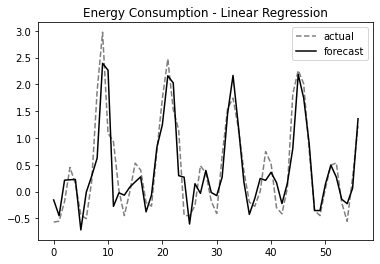

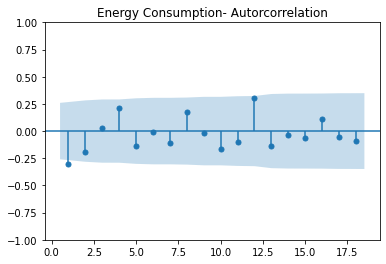

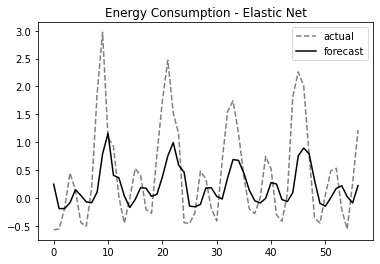

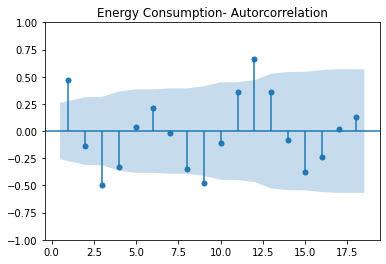

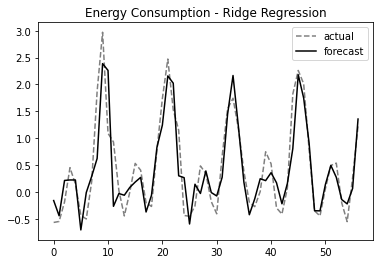

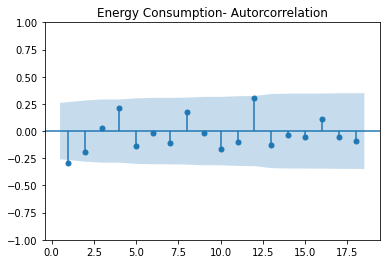

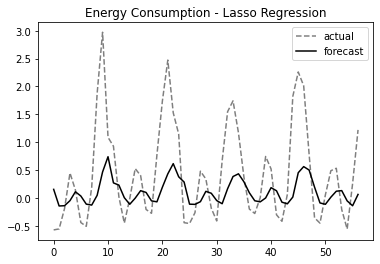

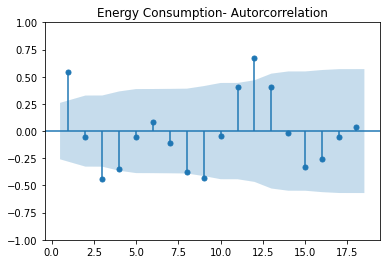

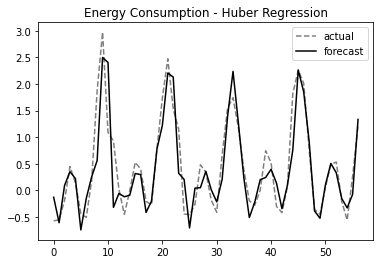

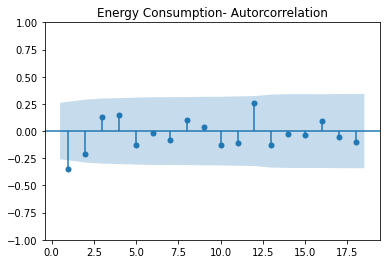

In [30]:
# Using the plot_results function on the energy consumption data

cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, en_results, 'Energy Consumption')



The three regression models; _Elastic Net, Lasso and Ridge_, add a regularization term to the objective function that we want to minimize. In Lasso regression the regularization term can recuce the coefficient of the least important features to zero, and thus eliminating them. This added penalization term is called **L1 Regularization**. 

In _Ridge Regression_, the regularization term is referred to as **L2 regularization** and can shrink the coefficients of the least important features but does not eliminate them. 

_Elastic Net Regression_ is a hybrid between the two by combining L1 and L2 regularization terms. 

_Regularization_ helps avoid overfitting during training and allows the model to better generalize. Additionally, L1 regularization can be used for _feature selection_ 



In [31]:
# We can inspect the coefficients to observe the effects

cols = ['Model Name', 'Model']
en_models = en_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.02739136  0.02052173  0.03768302  0.06630472  0.01417452 -0.08727704
  0.02856578 -0.13640839  0.14165493  0.70683461]
Elastic Net
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04077799 0.37835549]
Ridge Regression
[ 0.0273999   0.02054709  0.0377177   0.06625515  0.01414968 -0.08721396
  0.02844889 -0.13622568  0.14175768  0.7065417 ]
Lasso Regression
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2536153]


Observe how the Linear Regression model estimated higher coefficients for the last two features. On the other hand, ElasticNet regression model eliminated the first 8 features by estimating the coefficients to zero. The Ridge Regression model produced similar results as the Linear Regression model, reducing the weights of the least significant features (shrinking their effect). The Lasso Regression model only deemd the last feature as significant by eliminating the rest (with zero coefficients)

The coefficients from the four models suggest that the 10th feature (lag) is alone significant in making a future prediction. 



In [32]:
# Retrain the models using only the 10th feature

en_10 = en_reg[['y'], ['x_10']]
train_en10, test_en10 = split_data(en_10, test_split=0.10)
scaler_en10 = Standardize()
train_en10_s, test_en10_s = scaler_en.fit_transform(train_en10, test_en10)
en_10_results = train_different_models(train_en10_s, test_en10_s, regressors)
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_10_results = pd.DataFrame(en_results)
en_10_results[cols].sort_values('MASE')


InvalidIndexError: (['y'], ['x_10'])

## Multi-step forecasting using linear regression models with scikit-learn 

Here we will implement a _Recursive_ forecasting strategy. This is useful when we want to forecast further into the future beyond the out-of-sample data that we have at hand. 

It is still based on one-step forecasts that are reused (recursively) to make the next one-step prediction, and the process contiues (loop) until we get all the future steps (future horizons)



In [33]:
#cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
#dw_results = pd.DataFrame()

dw_results = train_different_models(train_dw_s, test_dw_s, regressors)
dw_results = pd.DataFrame(dw_results)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [34]:
dw_results

,Model Name,Model,RMSE,MAPE,MASE,yhat,resid,actual
0,Linear Regression,LinearRegression(),0.646648,1.037424,0.990057,"[-0.29619253865238826, -0.3145139435480653, -0...","[-0.28803221828815173, -0.2787225232150162, -0...","[-0.58422475694054, -0.5932364667630815, -0.63..."
1,Elastic Net,ElasticNet(alpha=0.5),0.737896,0.913599,1.300792,"[-0.3018190700137871, -0.24968002141505868, -0...","[-0.2824056869267529, -0.3435564453480228, -0....","[-0.58422475694054, -0.5932364667630815, -0.63..."
2,Ridge Regression,Ridge(alpha=0.5),0.646639,1.037273,0.990085,"[-0.29613870275885323, -0.3144177205378607, -0...","[-0.28808605418168676, -0.2788187462252208, -0...","[-0.58422475694054, -0.5932364667630815, -0.63..."
3,Lasso Regression,Lasso(alpha=0.5),0.814609,0.911730,1.468567,"[-0.17687814111972017, -0.14827924485769825, -...","[-0.4073466158208198, -0.4449572219053832, -0....","[-0.58422475694054, -0.5932364667630815, -0.63..."
4,Huber Regression,HuberRegressor(),0.656091,1.086846,0.969541,"[-0.3948230735298236, -0.375762818246764, -0.4...","[-0.1894016834107164, -0.2174736485163175, -0....","[-0.58422475694054, -0.5932364667630815, -0.63..."


In [35]:
# Extract the model and the model's name. 
models = dw_results[['Model Name', 'Model']]
models 

,Model Name,Model
0,Linear Regression,LinearRegression()
1,Elastic Net,ElasticNet(alpha=0.5)
2,Ridge Regression,Ridge(alpha=0.5)
3,Lasso Regression,Lasso(alpha=0.5)
4,Huber Regression,HuberRegressor()


In [36]:
# Create the multi_step_forecast function, which consists of a for loop that makes a one-step
# future forecast using the model's predict method. On each iteration or step, the estimated 
# value is used as input to produce the next one-step estimate for another future step

def multi_step_forecast(data, model, steps=10): 
    forecast = []
    for i in range(steps): 
        one_step_pred = model.predict(np.array(data).reshape(1,-1))[0]
        forecast.append(one_step_pred)
        _ = data.pop(0)
        data.append(one_step_pred)
    return np.array(forecast)


In [37]:
# Capture the last row from test_dw_s DataFrame. This represents the last 10 observations. 
# Recall that the DataFrame was created using a 10-period sliding window, and the last row
# represents observations from 2016-12-22 to 2016-21-31

dw_ms = test_dw_s.drop(columns = ['y']).iloc[-1].tolist()


In [38]:
# Loop through the models and pass the dw_ms list, the model, and the number of future steps
# (for example, 10 future steps) to the multi_step_forecast function 

frcst_dw = {}
models = dw_results[['Model Name', 'Model']]
for i in models.iterrows():
    pred = multi_step_forecast(dw_ms, steps=10,
                               model=i[1]['Model'])
    pred = scaler_dw.inverse_y(pred)
    frcst_dw[i[1]['Model Name']] = pred 

The predicted values are stored in the frcst_dw dictionary. The values have been inversely scaled to their original scale using the inverse_y method. 

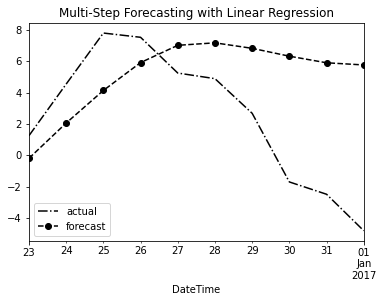

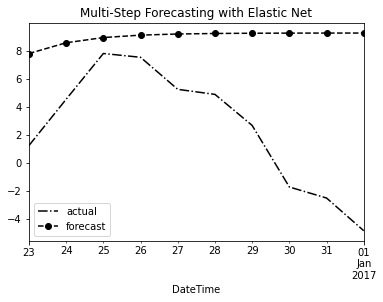

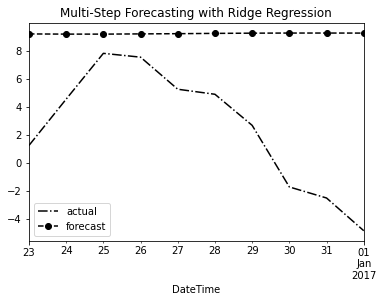

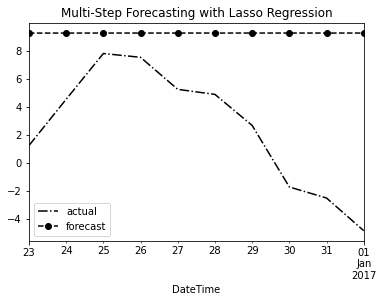

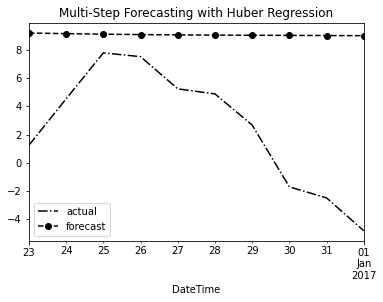

In [39]:
# Create a plot to compare actuals versus predicted for the daily temperature data

for name, pred in frcst_dw.items():
    actual = dw_cp.iloc[-10:]
    ax = actual.plot(style='k-.')
    pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
    plt.title(f'Multi-Step Forecasting with {name}')
    plt.legend(['actual', 'forecast'])
    plt.show()


A problem with the recursive strategy is that as we go further into the future, we are exclusively relying on the estimated values and any associated estimation errors. This can cause an accumulated effect of these errors as we progress further into the future, making the forecast highly biased. 


Here we will create a similar sliding window function as the one_step_forecast. However, the new function will also take an output window. For example a 10-sliding window for input and a 10-sliding window for output. This is a one-shot approach in which we provide a sequence as input and get a sequence as output. 

The multiple_output function takes a window_in parameter for the number of features to be generated, and a window_out parameter for the number of target variables to ne generated

In [40]:
def multiple_output(df, window_in, window_out):
    d = df.values 
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    print(len(idx))
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())

    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]
    df_xs = pd.DataFrame(x, index=idx, columns=cols_x)
    df_y = pd.DataFrame(y, index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()


The following is an example of using the multiple_output function to produce a sequence of 10 as input features and a sequence of 10 as target variables


In [41]:
win_in, win_out = 10, 10 
dw_mo = multiple_output(dw_cp, win_in, win_out)
dw_mo.columns 

2913


Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10',
       'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10'],
      dtype='object')

Train a linear regression model on this new dataset. Follow a similar process for splitting and scaling the data as previous

In [42]:
train_dw, test_dw = split_data(dw_mo, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw, test_dw)
X_train, y_train = train_dw_s.iloc[:, :win_in], train_dw_s.iloc[:, win_out:]
X_test, y_test = test_dw_s.iloc[:, :win_in], test_dw_s.iloc[:, win_out:]


In [43]:
# Now, we can fit the model and then make a prediction 

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

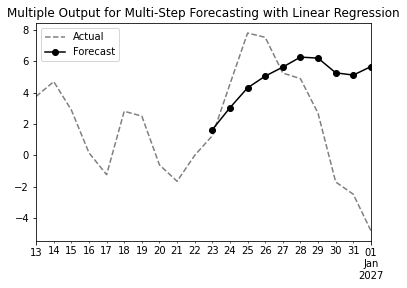

In [44]:
# Create a plot to compare the forecast against the out-of-sample or test data 

mo_pred = scaler_dw.inverse_y(lr.predict(X_test)[-1])
dates = pd.date_range('2026-12-13', freq='D', periods=20)
inputs, outputs = dates[:win_in], dates[win_out:]
pd.Series(test_dw.iloc[-1].values, index=dates).plot(style='k--', alpha=0.5)
pd.Series(mo_pred, index=outputs).plot(style='k-o')
plt.title('Multiple Output for Multi-Step Forecasting with Linear Regression')
plt.legend(['Actual', 'Forecast'])

## Forecasting using non-linear models with sktime 

_sktime_ is a unified ML framework for time series. 



In [45]:
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.all import (
        Deseasonalizer, Detrender, 
        temporal_train_test_split,
        mean_absolute_percentage_error as mape, 
        mean_squared_percentage_error as mspe,
        mean_squared_error as mse, 
        ForecastingHorizon, 
        NaiveForecaster,
        TransformedTargetForecaster,
        PolynomialTrendForecaster
)
from sktime.forecasting.compose import make_reduction


In [46]:
import sktime 
sktime.__version__

'0.17.1'

In [47]:
# Make a copy of the energy DF

df = energy.copy()

In [48]:
# Split the data into training and test sets 

train, test  = split_data(df)

We will explore five different regressors: 

* Linear Regression
* Random Forest Regressor
* Gradient Boosting Regressor 
* Extra Tree Regressor
* KNN Regressor 

We will include a Naive Forecaster with a mean strategy. The Naive Forecaster will be the baseline model to compare how the other regressors perform. Since the process for training the models is similar on all regressors, we will create a function, make_forecast, that takes in the training dataset, a regressor, the number of future horizons, and a window size. The function returns a pandas Series of the predicted values. 

In the make_forecast function, we will create a pipeline using the TransformedTargetForecaster class, to apply a set of transformations, for example removing trend, and seasonality using the Detrender nad Deseasonalizer classes. Here we will leverage the TransformedTargetForecaster class to chain the steps

In [49]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    forecaster = [
        ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))]
    
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor,
            strategy="recursive",
            window_length=window, 
            scitype='tabular-regressor'))
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
    else:
        model = regressor.fit(data.values)

    predicted = pd.Series(
        model.predict(fh=fh).reshape(-1), 
        index = test.index)
    
    return predicted 


Notice the use of the make_reduction function in the pipeline before fitting the model. This will create a reduced regression for the time series data. 

make_reduction will return a RecursiveTabularRegressionForecaster class and the default strategy parameter is recursive

In [50]:
# Create a dict for the different regressors so we can loop through and pass each one to the
# make_forecast function. Append predictions as a new column to the test DF

regressors = {
    'Naive Forecaster': NaiveForecaster(strategy='mean', sp=12), 
    'Linear Regression': LinearRegression(), 
    'K-Nn Regressor': KNeighborsRegressor(n_neighbors=5),
    'Extra Tree Regressor': ExtraTreesRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor() 
}

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg, window=15)
    

In [51]:
test.shape

(88, 7)

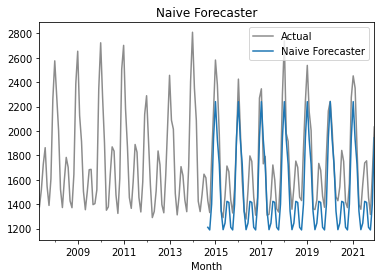

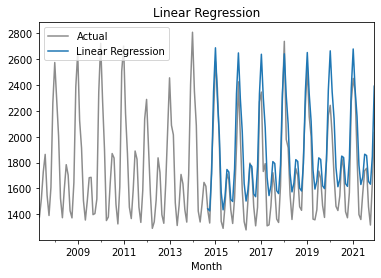

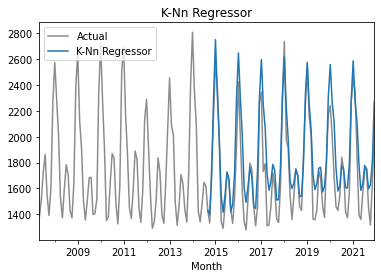

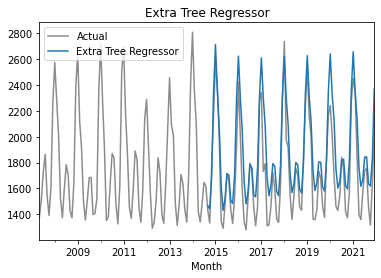

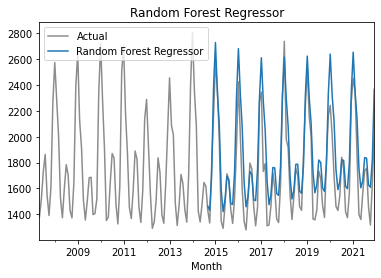

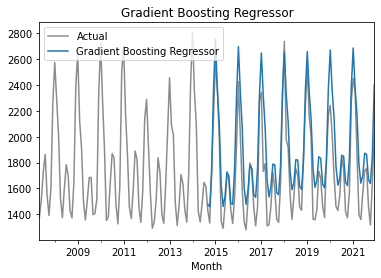

In [52]:
# Plot the predictions from each regressor against the test data. To do so, loop through the
# results in the test DF and keep in mind that the observed out-of-sample values are in the
# first columns

for i in test.iloc[:, 1:]:
    ax = df[-2*len(test):].plot(style='k-', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

Visually, aside from the Naive Forecaster, all the models seem to perform well. Using performance metrics is a much better approach to evaluate the models numerically. For example using MASE, sMAPE, MAPE and RMSE. Recall that Naive Forecaster is a baseline model from which we want to achieve better results. 

Create the evaluate function that will evaluate all the models:

In [53]:
def evaluate(df, train, sort_by='MASE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['y']
    y_predicted = df.drop(columns=['y'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
        evals.loc['MASE', p] = mase(y_truth, y_predicted[p], y_train=train)
    return evals.T.sort_values(by=sort_by)


The function will return a sorted DF by MASE which can be updated to one of MAPE, RMSE or sMAPE

In [54]:
# Call the function and pass the test and train sets:

evaluate(test, train)


,sMAPE,MAPE,RMSE,MASE
K-Nn Regressor,0.088718,0.095485,192.449319,0.685551
Random Forest Regressor,0.095945,0.103202,204.263262,0.752906
Extra Tree Regressor,0.100173,0.108047,209.783024,0.780684
Linear Regression,0.105661,0.114187,219.063673,0.828132
Gradient Boosting Regressor,0.108283,0.117169,224.954991,0.852808
Naive Forecaster,0.133619,0.123643,242.222293,0.957688


It looks like the KNN-Regressor model performed best, followed by the Random Forest model. both models can handle non-linearity. Overall, the regressors did outperform the Naive Forecaster model. 

<AxesSubplot:xlabel='Month'>

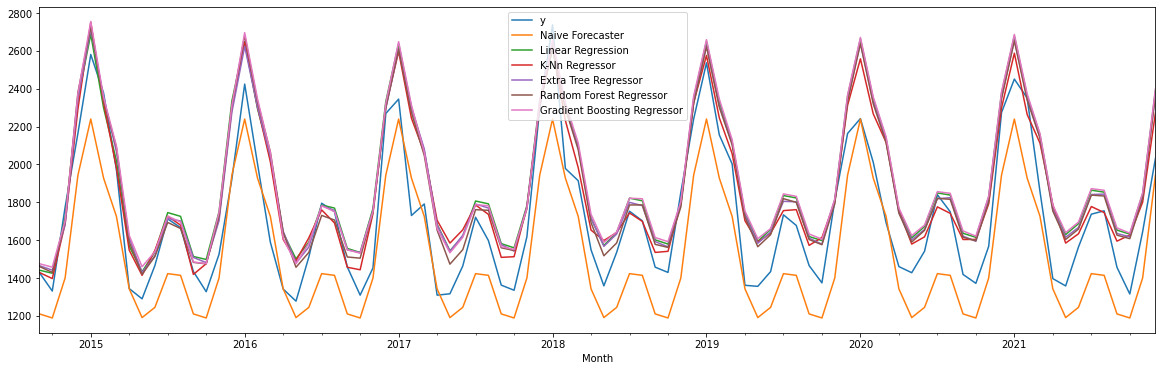

In [55]:
test.plot(subplots=False, figsize=(20, 6))

Let's see how the ML models compare against an ARIMA model using auto_arima from the pmdarima library. 

We will use auto_arima to determine the best (p,d,q) order for the non-seasonal components, and the (P, D, Q) order for the seasonal components

In [56]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)


In [57]:
# Examine the results with arima.summary 
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2988.064
Date:                            Wed, 26 Apr 2023   AIC                           5984.127
Time:                                    22:20:07   BIC                           6000.978
Sample:                                01-01-1973   HQIC                          5990.740
                                     - 08-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4294      0.037    -11.722      0.000      -0.501      -0.358
ar.S.L12       0.9982      0.001    728.448      0.000       0.996       1.001
ma.S.L12      -0.7859      0.030    -26.570      0.000      -0.844      -0.728
sigma2      8551.0752    415.464     20.582      0.000    7736.781    9365.369
===================================================================================
Ljung-Box (L1) (Q):                   9.08   Jarque-Bera (JB):                70.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
# Add the output predictions to the test DF and run the evaluate function again

test['ARIMA'] = arima.predict(n)
evaluate(test, train)


,sMAPE,MAPE,RMSE,MASE
K-Nn Regressor,0.088718,0.095485,192.449319,0.685551
ARIMA,0.098926,0.093273,184.711708,0.705402
Random Forest Regressor,0.095945,0.103202,204.263262,0.752906
Extra Tree Regressor,0.100173,0.108047,209.783024,0.780684
Linear Regression,0.105661,0.114187,219.063673,0.828132
Gradient Boosting Regressor,0.108283,0.117169,224.954991,0.852808
Naive Forecaster,0.133619,0.123643,242.222293,0.957688


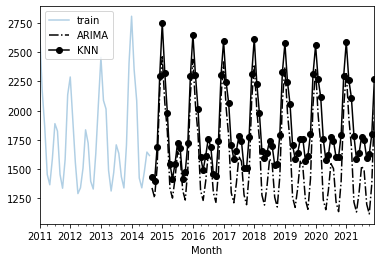

In [59]:
# We can plot the two best models to see how they compare visually

ax = train.loc['2011':].plot(style='-', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k-.')
test['K-Nn Regressor'].plot(ax=ax, style='k-o')
plt.legend(['train', 'ARIMA', 'KNN'])

The ARIMA model did a decent job overall compared to more advanced ML regressors. This is sometimes the case with smaller univariate time series. Keep in mind that the ML models are not optimized yet (hyperparameter tuning) while the ARIMA model was optimized by auto_arima to find the best hyperparameters (the seasonal and non-seasonal orders). ML algorithms are great for working with more complex multivariate time series data.

ML optimization with hyperparameter tuning is an essential step to ensure we are getting the best configuration and performance for the model of choice. 

## Optimizing a forecasting model with hyperparameter tuning

Here we will examine how we can find optimal hyperparameter values for the KNN regressor. We will perform a cross-validated grid search using sktime's _ForecastingGridSearchCV_ 



In [60]:
from sktime.forecasting.all import (
    ForecastingGridSearchCV, 
    SlidingWindowSplitter, 
    MeanAbsolutePercentageError
)

We will build a KNN regression model and then work on optimizing the model with hyperparameter tuning. The following steps will use the _energy_ DF, but we should be able to apply the same steps on the other datasets. 

In [61]:
# Make a copy of the energy DF and split the data into training and test sets

df = energy.copy()

In [62]:
train, test = split_data(df)

In [63]:
# use the TransformedTargetForecaster class to create a pipeline for transforming the TS

n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)

forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)), 
     ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))), 
     ("forecast", 
      make_reduction(
    KNeighborsRegressor(),
    scitype="tabular-regressor",
    window_length=12,
    strategy="recursive",
      ), ), ])
      

In [64]:
# Train the model using the fit method
forecaster.fit(train.values)


TransformedTargetForecaster(steps=[('deseasonalize',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=12)),
                                   ('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                                                         window_length=12))])

In [65]:
test['KNN-Regressor'] = forecaster.predict(fh)

In [66]:
# We will use the evaluate function to evaluate the model
evaluate(test, train)


,sMAPE,MAPE,RMSE,MASE
KNN-Regressor,0.090378,0.097746,225.568315,0.751772


In [67]:
# Inspect the parameters available from the forecaster object with the get_params method
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'detrend__model': 'additive',
 'forecast__estimator__algorithm': 'auto',
 'forecast__estimator__leaf_size': 30,
 'forecast__estimator__metric': 'minkowski',
 'forecast__estimator__metric_params':

In [68]:
# Create a dictionary to define the hyperparameters we want to optimize against

hyperparameters_grid = {
    "forecast__estimator__n_neighbors": [i for i in range(3,11)],
    "deseasonalize__model": ['multiplicative', 'additive'],
    "forecast__estimator__p": [1,2]}



To perform cross-validation on time series, we will use the SlidingWindowSplitter class and define a sliding window at 80% of the df (notice we are not using the train DF). This means that 80% of the data will be allocated for the training fold and while the testing fold based on fh or forecast horizon. Create the grid search object grid_csv using the ForecastingGridSearchCV class

In [69]:
cv = SlidingWindowSplitter(window_length=int(len(train) * 0.70), fh=fh)
smape = MeanAbsolutePercentageError(symmetric=True)
grid_csv = ForecastingGridSearchCV(
    forecaster, 
    strategy="refit", 
    cv=cv, 
    param_grid = hyperparameters_grid, 
    scoring =smape, 
    return_n_best_forecasters=1, 
    verbose=1)


Currently, sktime only supports grid search and random search 

Notice, that verbose is set to 1 to print a summary for the number of computations. The default is verbose=0, which will not print anything


In [70]:
# To initiate the process and train the different models, use the fit method

grid_csv.fit(train.values, fh=fh)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relat...
                                                                       Detrender(forecaster=PolynomialTrendForecaster())),
                                                                      ('forecast',
                                                                       RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                                                                                            window_length=12))]),


In [71]:
# Once the grid search process is completed, we can access the list of optimal hyperparameters
# using the best_params attribute:

grid_csv.best_params_


{'deseasonalize__model': 'additive',
 'forecast__estimator__n_neighbors': 8,
 'forecast__estimator__p': 1}

In [72]:
# We can use the predict method from the grid_csv object to produce a forecast
# Store the results as a new column in the test DF to compare the results from the optimized
# hyperparameters against the default values used earlier

test['KNN_optimized'] = grid_csv.predict(fh)


In [73]:
# Use the evaluate function to compare the two results:
evaluate(test, train)

,sMAPE,MAPE,RMSE,MASE
KNN_optimized,0.092236,0.098938,193.448985,0.714911
KNN-Regressor,0.090378,0.097746,225.568315,0.751772


To get more insight into the performance at each fold, we can use the cv_results_ attribute. This should produce a DF of 32 rows, one for each of the 32 combinations, and the mean scores are for the 2 folds:

The below code will return a DF showing the average scores of all the folds for each combinaton (model)


In [74]:
grid_csv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.067171,0.018240,0.031207,"{'deseasonalize__model': 'multiplicative', 'fo...",29.0
1,0.067460,0.018115,0.028277,"{'deseasonalize__model': 'multiplicative', 'fo...",32.0
2,0.066616,0.015450,0.027200,"{'deseasonalize__model': 'multiplicative', 'fo...",24.0
3,0.066275,0.015460,0.027718,"{'deseasonalize__model': 'multiplicative', 'fo...",20.0
4,0.065891,0.015658,0.027610,"{'deseasonalize__model': 'multiplicative', 'fo...",14.0
5,0.065588,0.015539,0.027354,"{'deseasonalize__model': 'multiplicative', 'fo...",5.0
6,0.066408,0.015344,0.026473,"{'deseasonalize__model': 'multiplicative', 'fo...",22.0
7,0.065849,0.015534,0.027658,"{'deseasonalize__model': 'multiplicative', 'fo...",13.0
8,0.066756,0.015766,0.026254,"{'deseasonalize__model': 'multiplicative', 'fo...",26.0
9,0.066130,0.016341,0.027708,"{'deseasonalize__model': 'multiplicative', 'fo...",17.0


In [75]:
# If we want to store the model or see the full list of parameters, we can use the 
# best_forecaster_ attribute:

model = grid_csv.best_forecaster_
model.get_params()

{'steps': [('deseasonalize', Deseasonalizer(sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=8,
                                                                      p=1),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=8,
                                                                    p=1),
                                      window_length=12),
 'deseasonalize__model': 'additive',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'detrend__model': 'additive',
 'forecast__estimator__algorithm': 'auto',
 '

## Forecasting with exogenous variables and ensemble learning 

Here we will be working with:

* multivariate time series 
* ensemble forecasters

The EnsembleForecaster class takes in a list of multiple regressors, each regressor gets trained and collectively contribute in making a prediction. This is accomplished by taking the average of the individual predictions from each regressor. We can think of this as the power of the collective. We will use the same regressors we used earlier: Linear Regression, Random Forest Regressor, Gradient Boosting Regressor, Support Vector Machines Regressor

We will use a Naive Regressor as the baseline to compare with EnsembleForecaster. Additionally, we will use exogenous variables with the Ensemble Forecaster to model a multivariate time series. We can use any regressor that accepts exogenous variables. 

In [76]:
from sktime.forecasting.all import EnsembleForecaster
from sklearn.svm import SVR 
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.datasets import load_macroeconomic

In [77]:
# Load the macroeconomic data, which contains 12 features

econ = load_macroeconomic()
cols = ['realgdp', 'realdpi', 'tbilrate', 'unemp', 'infl']
econ_df = econ[cols]
econ_df.shape 


(203, 5)

We want to predict the unemployment rate using exogenous variables. The exogenous variables include: _real gross domestic product_, _real disposable personal income_, _treasury bill rate_ and _inflation_. This is different from VAR model which is used with multivariate time series and treats the variables as endogenous variables. 

In [79]:
# The reference for the endogenous or univariate, variable in sktime is y and x for the 
# exogenous variables. Split the data into y_train, y_test, exog_train and exog_test

y = econ_df['unemp']
exog = econ_df.drop(columns=['unemp'])
test_size = 0.1 
y_train, y_test = split_data(y, test_split=test_size)
exog_train, exog_test = split_data(exog, test_split=test_size)


In [80]:
# Create a list of the regressors to be used with EnsembleForecaster

regressors = [ 
    ("LinearRegression", make_reduction(LinearRegression())), 
    ("RandomForest", make_reduction(RandomForestRegressor())), 
    ("SupportVectorRegressor", make_reduction(SVR())), 
    ("GradientBoosting", make_reduction(GradientBoostingRegressor()))
]

In [81]:
# Create an instance of the EnsembleForecaster class and the NaiveForecaster() class with 
# default hyperparameter values: 

ensemble = EnsembleForecaster(regressors)


In [82]:
naive = NaiveForecaster()

In [83]:
# Train both forecasters on the training set with the fit method. We will supply the univariate
# time series (y) along with the exogenous variables (x)

ensemble.fit(y=y_train, X=exog_train)


EnsembleForecaster(forecasters=[('LinearRegression',
                                 RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
                                ('RandomForest',
                                 RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
                                ('SupportVectorRegressor',
                                 RecursiveTabularRegressionForecaster(estimator=SVR())),
                                ('GradientBoosting',
                                 RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))])

In [84]:
naive.fit(y=y_train, X=exog_train)

NaiveForecaster()

In [85]:
# Once training is complete, we can use the predict method supplying the forecast horizon
# and the test exogenous variables. This will be the unseen exog_test set

fh = ForecastingHorizon(y_test.index, is_relative=None)


In [92]:
y_hat = pd.DataFrame(y_test).rename(columns={'unemp': 'test'})
y_hat["EnsembleForecaster"] = ensemble.predict(fh=fh, X=exog_test)
y_hat["NaiveForecaster"] = naive.predict(fh=fh, X=exog_test)


In [87]:
y_hat["RandomForest"] = naive.predict(fh=fh, X=exog_test)


In [94]:
# Use the evaluate function

y_hat.rename(columns={'test': 'y'}, inplace=True)


In [95]:
evaluate(y_hat, y_train)

,sMAPE,MAPE,RMSE,MASE
EnsembleForecaster,0.141595,0.138614,1.236051,3.783562
NaiveForecaster,0.170823,0.160553,1.544021,4.528230


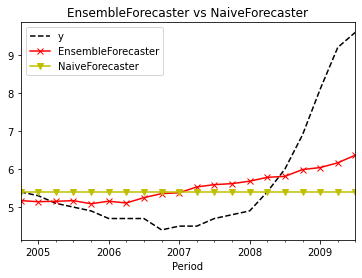

In [96]:
styles = ['k--', 'rx-', 'yv-']
for col, s in zip(y_hat, styles):
    y_hat[col].plot(style=s, label=col, 
                    title='EnsembleForecaster vs NaiveForecaster')
    
plt.legend()

Remember that neither of the models were optimized. Ideally, we can use k-fold cross-validation when training or a cross-validated grid search

#### How it works:

The EnsembleForecaster class from sktime is similar to the VotingRegressor clas sin sklearn. Both are ensemble estimators that fit several regressors and collectively, they produce a prediction through an aggregate function. Unlike VotingRegressor in sklearn, EnsembleForecaster allows us to change the aggfunc parameter to either mean (default), median, min or max. When making a prediction with the predict method, only one prediction per one-step forecast horizon is produced. We will not get multiple predictions from each base regressor, but rather the aggregated value (for example the mean) from all the base regressors. 

Using a multivariate time series is made simple by using exogenous variables. Similarly, in statsmodels, an ARIMA or SARIMA model has an exog parameter. An ARIMA with exogenous variables is referred to as ARIMAX. Similarly, a seasonal ARIMA with exogenous variables is referred to as SARIMAX. 

The AutoEnsembleForecaster class in sktime behaves similar to the EnsembleForecaster class. The difference is that the AutoEnsembleForecaster class will calculate the optimal weights for each of the regressors passed. The AutoEnsembleForecaster class has a regressor parameter that takes a list of regressors and estimates a weight for each class. In other words, not all regressors are treated equal. If none are provided, then the GradientBoostingRegressor class is used instead, with a default max_depth=5

Using the same list of regressors, we will use AutoEnsembleForecaster and compare the results with NaiveForecaster and EnsembleForecaster


In [97]:
from sktime.forecasting.compose import AutoEnsembleForecaster
auto = AutoEnsembleForecaster(forecasters=regressors, method='feature-importance')
auto.fit(y=y_train, X=exog_train)
auto.weights_

[0.6510632847066852,
 0.054208526369812,
 0.21028981524208126,
 0.08443837368142174]

The order of the weights listed are based on the order from the regressor list provided.

Using the predict method, let's compare the results:

In [98]:
y_hat['AutoEnsembleForecaster'] = auto.predict(fh=fh, X=exog_test)
evaluate(y_hat, y_train)

,sMAPE,MAPE,RMSE,MASE
EnsembleForecaster,0.141595,0.138614,1.236051,3.783562
AutoEnsembleForecaster,0.151887,0.165931,1.048238,3.880439
NaiveForecaster,0.170823,0.160553,1.544021,4.528230


Keep in mind that the number and type of regressors (or forecasters) used in both EnsembleForecaster and AutoEnsembleForecaster will have a significant impact on the overall quality. Keep in mind that none of these models have been optimized and are based on default hyperparameter values